In [10]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmaps
import dyl_function_slope as dyl
import areamean_dhq as dhq
from matplotlib.colors import BoundaryNorm
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from cartopy.util import add_cyclic_point
ccmap1 = cmaps.NEO_div_vegetation_a
ccmap = cmaps.ncl_default
plt.rcParams['font.family'] = 'Helvetica'

# 0 绘制垂向剖面的函数

In [11]:
def plot_meri_section(ax1, lat,level,level_label,
                      meri_data,meri_data_levels,ccmap,meri_clim,meri_clim_levels,consistency,set_xticks,
                      left_title,right_title,colorbar_label,color_bar_ticks,sequence):

    cycle_data, cycle_lat = add_cyclic_point(meri_data, coord=lat)
    lat = np.asarray(lat)
    level = np.asarray(level)
    cycle_lat, cycle_level = np.meshgrid(cycle_lat, np.arange(level.shape[0]))
    #cycle_MON = cycle_MON.filled(np.nan)
    cycle_data = cycle_data.filled(np.nan)

    c1 = ax1.contourf(cycle_lat, cycle_level, cycle_data, cmap=ccmap, levels=meri_data_levels, extend='both')
    cycle_clim, cycle_mon = add_cyclic_point(meri_clim, coord=lat)
    c2 = ax1.contour(cycle_lat, cycle_level, cycle_clim, levels=meri_clim_levels, colors='k', alpha=0.6,
                         linewidths=.5)
    ax1.clabel(c2, inline=True, fontsize=6)

    if consistency is not None:
        cycle_dot, cycle_mon = add_cyclic_point(consistency, coord=lat)
        significance = np.ma.masked_where(cycle_dot == False, cycle_dot)
        c3 = ax1.contourf(cycle_lat, cycle_level, significance, colors='none', hatches=['////'])

        if hasattr(c3, 'collections'):
            collections = c3.collections
        else:
            collections = [c3]
        # 设置 hatch 样式
        for collection in collections:
            collection.set_edgecolor('grey')
            collection.set_linewidth(0)
    '''if consistency is not None:
        # 确保一致性掩码也添加周期性点
        cycle_dot, _ = add_cyclic_point(consistency, coord=lat)
        # 在plot_trend_and_significance函数内部，在绘制显著性的代码块之后，添加以下代码来绘制一致性阴影
        # 创建网格
        dot_spacing = 4
        # 设置打点间距，避免过于密集
        mask_reduced = cycle_dot[::dot_spacing, ::dot_spacing]
        lon_reduced = cycle_lat[::dot_spacing, ::dot_spacing]
        lat_reduced = cycle_level[::dot_spacing, ::dot_spacing]
        # 只绘制显著的点
        significant_points = mask_reduced
        lon_sig = lon_reduced[significant_points]
        lat_sig = lat_reduced[significant_points]
        # 绘制打点
        ax1.scatter(lon_sig, lat_sig, color='grey', s=.25,alpha=0.6)'''


    ax1.set_xticks(set_xticks)  # 指定要显示的经纬度
    ax1.xaxis.set_major_formatter(LatitudeFormatter())  # 刻度格式转换为经纬度样式
    ax1.yaxis.set_ticks(np.arange(level.shape[0]), level_label)  # 指定要显示的经纬度
    ax1.tick_params(axis='x', labelsize=7)  # 设置x轴刻度数字大小
    ax1.tick_params(axis='y', labelsize=7)  # 设置y轴刻度数字大小
    ax1.text(-0.15, 1.15, sequence, transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='left')
    ax1.set_title(left_title, loc='left', fontsize=7)
    ax1.set_title(right_title, loc='right', fontsize=7)
    if sequence == 'A':
        ax1.set_ylabel('Level (hPa)', fontsize=7)

    '''cb = fig.colorbar(c1, orientation='vertical', shrink=0.75, fraction=0.1, pad=0.03, extend='both')
    cb.ax.yaxis.set_major_locator(MultipleLocator(0.2))
    # cb.ax.set_size([0.5,0.2])
    cb.set_ticks(color_bar_ticks)
    cb.ax.tick_params(axis='y', which='major', direction='in', length=4, labelsize=6)
    # cb.ax.tick_params(which='minor', direction='in', length=5)
    cb.set_label(label=colorbar_label, fontsize=8)
    cb.ax.tick_params(labelsize=8)'''

    return c1

# 1 开始处理数据，加载EXT TI1,DEF,VWS

In [12]:
IN_DIR = "/home/dongyl/Work2_2025/ERA5_daily"
YEARS = list(range(1980, 2020+1))#2015
LAT_MIN, LAT_MAX = 20, 60
Q=0.95
era5_TI_freq_ay = []
era5_VWS_freq_ay = []
era5_DEF_freq_ay = []
era5_TI_freq_ay_aream = []
era5_VWS_freq_ay_aream = []
era5_DEF_freq_ay_aream = []
for year in YEARS:
    TI_freq = xr.open_dataset(f"{IN_DIR}/era5_TI1_exceed_pct_{year}_{int(Q * 100)}p.nc")
    freq_subset = TI_freq.sel(lat=slice(10, 60))
    TI_freq = freq_subset["frequency"][::-1]
    print(TI_freq.plev)
    era5_TI_freq_ay.append(TI_freq)
    print(f"{year} TI_freq loaded ")
    era5_TI_freq_ay_aream.append(dhq.mask_am(TI_freq.sel(lat=slice(20, 40))))

    VWS_freq = xr.open_dataset(f"{IN_DIR}/era5_VWS_exceed_pct_{year}_{int(Q * 100)}p.nc")
    freq_subset = VWS_freq.sel(lat=slice(10, 60))
    VWS_freq = freq_subset["frequency"][::-1]
    era5_VWS_freq_ay.append(VWS_freq)
    print(f"{year} VWS_freq loaded ")
    era5_VWS_freq_ay_aream.append(dhq.mask_am(VWS_freq.sel(lat=slice(20, 40))))

    DEF_freq = xr.open_dataset(f"{IN_DIR}/era5_DEF_exceed_pct_{year}_{int(Q * 100)}p.nc")
    freq_subset = DEF_freq.sel(lat=slice(10, 60))
    DEF_freq = freq_subset["frequency"][::-1]
    era5_DEF_freq_ay.append(DEF_freq)
    print(f"{year} DEF_freq loaded ")
    era5_DEF_freq_ay_aream.append(dhq.mask_am(DEF_freq.sel(lat=slice(20, 40))))

era5_TI_freq_ay_stack = np.stack(era5_TI_freq_ay, axis=0)
era5_VWS_freq_ay_stack = np.stack(era5_VWS_freq_ay, axis=0)
era5_DEF_freq_ay_stack = np.stack(era5_DEF_freq_ay, axis=0)

era5_TI_freq_ay_zonmean = np.nanmean(era5_TI_freq_ay_stack,axis=-1)
era5_VWS_freq_ay_zonmean = np.nanmean(era5_VWS_freq_ay_stack,axis=-1)
era5_DEF_freq_ay_zonmean = np.nanmean(era5_DEF_freq_ay_stack,axis=-1)

era5_TI_freq_ay_aream = np.stack(era5_TI_freq_ay_aream, axis=0)
era5_DEF_freq_ay_aream = np.stack(era5_DEF_freq_ay_aream, axis=0)
era5_VWS_freq_ay_aream = np.stack(era5_VWS_freq_ay_aream, axis=0)
'''era5_TI_freq_ay_aream = dhq.areamean_func_4D(era5_TI_freq_ay_stack,slice(20,40),TI_freq.lat)
era5_VWS_freq_ay_aream = dhq.areamean_func_4D(era5_VWS_freq_ay_stack,slice(20,40),VWS_freq.lat)
era5_DEF_freq_ay_aream = dhq.areamean_func_4D(era5_DEF_freq_ay_stack,slice(20,40),DEF_freq.lat)
print(era5_TI_freq_ay_aream.shape)'''

era5_TI_freq_trend, era5_TI_freq_p_values = dyl.calculate_trend_3D_ndarray(era5_TI_freq_ay_zonmean)
era5_TI_mask_trend = era5_TI_freq_p_values < 0.05
era5_TI_significant_points= np.where(era5_TI_mask_trend, True, False)
era5_TI_freq_clim = np.nanmean(era5_TI_freq_ay_zonmean,axis=0)
era5_TI_freq_aream_trend, era5_TI_freq_aream_p_values = dyl.calculate_trend_2D_zonmean(era5_TI_freq_ay_aream)
print(era5_TI_freq_aream_trend)
era5_TI_freq_aream_clim = np.nanmean(era5_TI_freq_ay_aream,axis=0)
print(era5_TI_freq_aream_clim)

era5_VWS_freq_trend, era5_VWS_freq_p_values = dyl.calculate_trend_3D_ndarray(era5_VWS_freq_ay_zonmean)
era5_VWS_mask_trend = era5_VWS_freq_p_values < 0.05
era5_VWS_significant_points= np.where(era5_VWS_mask_trend, True, False)
era5_VWS_freq_clim = np.nanmean(era5_VWS_freq_ay_zonmean,axis=0)
era5_VWS_freq_aream_trend, era5_VWS_freq_aream_p_values = dyl.calculate_trend_2D_zonmean(era5_VWS_freq_ay_aream)
era5_VWS_freq_aream_clim = np.nanmean(era5_VWS_freq_ay_aream,axis=0)

era5_DEF_freq_trend, era5_DEF_freq_p_values = dyl.calculate_trend_3D_ndarray(era5_DEF_freq_ay_zonmean)
era5_DEF_mask_trend = era5_DEF_freq_p_values < 0.05
era5_DEF_significant_points= np.where(era5_DEF_mask_trend, True, False)
era5_DEF_freq_clim = np.nanmean(era5_DEF_freq_ay_zonmean,axis=0)
era5_DEF_freq_aream_trend, era5_DEF_freq_aream_p_values = dyl.calculate_trend_2D_zonmean(era5_DEF_freq_ay_aream)
era5_DEF_freq_aream_clim = np.nanmean(era5_DEF_freq_ay_aream,axis=0)
print(era5_DEF_freq_aream_trend.shape)

<xarray.DataArray 'plev' (plev: 6)> Size: 48B
array([30000., 25000., 20000., 15000., 10000.,  5000.])
Coordinates:
  * plev      (plev) float64 48B 3e+04 2.5e+04 2e+04 1.5e+04 1e+04 5e+03
    quantile  float64 8B ...
1980 TI_freq loaded 
1980 VWS_freq loaded 
1980 DEF_freq loaded 
<xarray.DataArray 'plev' (plev: 6)> Size: 48B
array([30000., 25000., 20000., 15000., 10000.,  5000.])
Coordinates:
  * plev      (plev) float64 48B 3e+04 2.5e+04 2e+04 1.5e+04 1e+04 5e+03
    quantile  float64 8B ...
1981 TI_freq loaded 
1981 VWS_freq loaded 
1981 DEF_freq loaded 
<xarray.DataArray 'plev' (plev: 6)> Size: 48B
array([30000., 25000., 20000., 15000., 10000.,  5000.])
Coordinates:
  * plev      (plev) float64 48B 3e+04 2.5e+04 2e+04 1.5e+04 1e+04 5e+03
    quantile  float64 8B ...
1982 TI_freq loaded 
1982 VWS_freq loaded 
1982 DEF_freq loaded 
<xarray.DataArray 'plev' (plev: 6)> Size: 48B
array([30000., 25000., 20000., 15000., 10000.,  5000.])
Coordinates:
  * plev      (plev) float64 48B 3e+04 

In [13]:
IN_DIR = "/home/dongyl/Work2024/Tl/saved_npy/model_turbulence_data/h+ssp585_1980-2020/95p_frequency"

YEARS = list(range(1979, 2024+1))#2015
LAT_MIN, LAT_MAX = 20, 60
Q=0.95

models = ["BCC-CSM2-MR","CanESM5", "CESM2-WACCM","FGOALS-g3","IITM-ESM",
          "KACE-1-0-G",'INM-CM5-0',"IPSL-CM6A-LR","MIROC6", "MPI-ESM1-2-HR",
          "MRI-ESM2-0","NorESM2-LM","NorESM2-MM","TaiESM1"]#的VWS95p_frequency有问题，10.9发现，回去重新运行
#############1 计算TI1 VWS DEF垂向剖面##########################################
TI_all_models_trend_list=[]
TI_all_models_list=[]
TI_all_models_p_values_list=[]
VWS_all_models_trend_list=[]
VWS_all_models_list=[]
VWS_all_models_p_values_list=[]
DEF_all_models_trend_list=[]
DEF_all_models_list=[]
DEF_all_models_p_values_list=[]
TI_all_models_aream_trend_list=[]
TI_all_models_aream_list=[]
TI_all_models_aream_p_values_list=[]
VWS_all_models_aream_trend_list=[]
VWS_all_models_aream_list=[]
VWS_all_models_aream_p_values_list=[]
DEF_all_models_aream_trend_list=[]
DEF_all_models_aream_list=[]
DEF_all_models_aream_p_values_list=[]
#level_label=['500','300','250','200','150','100','50', '10']
for model in models:
    print(f"Processing {model}")
    file1 = f"{IN_DIR}/TI1_h+ssp585_{model}_1980-2020_exceed_pct_{int(Q * 100)}p.nc"
    file2 = f"{IN_DIR}/VWS_h+ssp585_{model}_1980-2020_exceed_pct_{int(Q * 100)}p.nc"
    file3 = f"{IN_DIR}/DEF_h+ssp585_{model}_1980-2020_exceed_pct_{int(Q * 100)}p.nc"
    TI_array= xr.open_dataset(file1)["frequency"].sel(lat=slice(10, 60))
    VWS_array= xr.open_dataset(file2)["frequency"].sel(lat=slice(10, 60))
    DEF_array= xr.open_dataset(file3)["frequency"].sel(lat=slice(10, 60))
    print(VWS_array.dims)#('year', 'plev', 'lat', 'lon')
    print(VWS_array.plev)
    #计算区域平均的TI,VWS,DEF
    TI_all_models_aream_list.append(dhq.mask_am4D(xr.open_dataset(file1)["frequency"].sel(lat=slice(20, 40))))
    print(TI_array.lat)
    print(dhq.mask_am4D(xr.open_dataset(file1)["frequency"].sel(lat=slice(20, 40))))
    VWS_all_models_aream_list.append(dhq.mask_am4D(xr.open_dataset(file2)["frequency"].sel(lat=slice(20, 40))))
    DEF_all_models_aream_list.append(dhq.mask_am4D(xr.open_dataset(file3)["frequency"].sel(lat=slice(20, 40))))
    TI_levels = TI_array.mean(dim='lon', skipna=True)
    VWS_levels = VWS_array.mean(dim='lon', skipna=True)
    DEF_levels = DEF_array.mean(dim='lon', skipna=True)
    TI_all_models_list.append(TI_levels.values)
    VWS_all_models_list.append(VWS_levels.values)
    DEF_all_models_list.append(DEF_levels.values)

    TI_levels_trend,TI_levels_p_level = dyl.get_slope_p_3D(TI_levels)
    VWS_levels_trend,VWS_levels_p_level = dyl.get_slope_p_3D(VWS_levels)
    DEF_levels_trend,DEF_levels_p_level = dyl.get_slope_p_3D(DEF_levels)
    TI_levels_aream_trend,TI_levels_aream_p_level = dyl.calculate_trend_2D(dhq.mask_am4D(xr.open_dataset(file1)["frequency"].sel(lat=slice(20, 40))))
    print(TI_levels_aream_trend)
    VWS_levels_aream_trend,VWS_levels_aream_p_level = dyl.calculate_trend_2D(dhq.mask_am4D(xr.open_dataset(file2)["frequency"].sel(lat=slice(20, 40))))
    DEF_levels_aream_trend,DEF_levels_aream_p_level = dyl.calculate_trend_2D(dhq.mask_am4D(xr.open_dataset(file3)["frequency"].sel(lat=slice(20, 40))))
    
    TI_all_models_trend_list.append(TI_levels_trend)
    TI_all_models_p_values_list.append(TI_levels_p_level)
    VWS_all_models_trend_list.append(VWS_levels_trend)
    VWS_all_models_p_values_list.append(VWS_levels_p_level)
    DEF_all_models_trend_list.append(DEF_levels_trend)
    DEF_all_models_p_values_list.append(DEF_levels_p_level)
    
    TI_all_models_aream_trend_list.append(TI_levels_aream_trend)
    TI_all_models_aream_p_values_list.append(TI_levels_aream_p_level)
    VWS_all_models_aream_trend_list.append(VWS_levels_aream_trend)
    VWS_all_models_aream_p_values_list.append(VWS_levels_aream_p_level)
    DEF_all_models_aream_trend_list.append(DEF_levels_aream_trend)
    DEF_all_models_aream_p_values_list.append(DEF_levels_aream_p_level)

TI_all_models_trend_stack = np.stack(TI_all_models_trend_list, axis=0)
TI_all_models_p_values_stack = np.stack(TI_all_models_p_values_list, axis=0)
TI_all_models_array = np.stack(TI_all_models_list,axis=0)
TI_freq_ay_zonmean = np.nanmean(TI_all_models_array,axis=0)
TI_all_models_aream_stack = np.stack(TI_all_models_aream_list,axis=0)
TI_all_models_aream_clim_stack = np.nanmean(TI_all_models_aream_stack,axis=1)
TI_all_models_aeram_trend_stack = np.stack(TI_all_models_aream_trend_list,axis=0)
TI_all_models_aeram_p_values_stack = np.stack(TI_all_models_aream_p_values_list,axis=0)
print(TI_all_models_aream_clim_stack.shape)
print(TI_all_models_aeram_trend_stack.shape)
print(TI_all_models_aeram_p_values_stack.shape)

VWS_all_models_trend_stack = np.stack(VWS_all_models_trend_list, axis=0)
VWS_all_models_p_values_stack = np.stack(VWS_all_models_p_values_list, axis=0)
VWS_all_models_array = np.stack(VWS_all_models_list,axis=0)
VWS_freq_ay_zonmean = np.nanmean(VWS_all_models_array,axis=0)
VWS_all_models_aream_stack = np.stack(VWS_all_models_aream_list,axis=0)
VWS_all_models_aream_clim_stack = np.nanmean(VWS_all_models_aream_stack,axis=1)
VWS_all_models_aeram_trend_stack = np.stack(VWS_all_models_aream_trend_list,axis=0)
VWS_all_models_aeram_p_values_stack = np.stack(VWS_all_models_aream_p_values_list,axis=0)

DEF_all_models_trend_stack = np.stack(DEF_all_models_trend_list, axis=0)
DEF_all_models_p_values_stack = np.stack(DEF_all_models_p_values_list, axis=0)
DEF_all_models_array = np.stack(DEF_all_models_list,axis=0)
DEF_freq_ay_zonmean = np.nanmean(DEF_all_models_array,axis=0)
DEF_all_models_aream_stack = np.stack(DEF_all_models_aream_list,axis=0)
DEF_all_models_aream_clim_stack = np.nanmean(DEF_all_models_aream_stack,axis=1)
DEF_all_models_aeram_trend_stack = np.stack(DEF_all_models_aream_trend_list,axis=0)
DEF_all_models_aeram_p_values_stack = np.stack(DEF_all_models_aream_p_values_list,axis=0)


TI_freq_trend, TI_freq_p_values = dyl.calculate_trend_3D_ndarray(TI_freq_ay_zonmean)
TI_mask_trend = TI_freq_p_values < 0.05
TI_significant_points= np.where(TI_mask_trend, True, False)
TI_freq_clim = np.nanmean(TI_freq_ay_zonmean,axis=0)
VWS_freq_trend, VWS_freq_p_values = dyl.calculate_trend_3D_ndarray(VWS_freq_ay_zonmean)
VWS_mask_trend = VWS_freq_p_values < 0.05
VWS_significant_points= np.where(VWS_mask_trend, True, False)
VWS_freq_clim = np.nanmean(VWS_freq_ay_zonmean,axis=0)
DEF_freq_trend, DEF_freq_p_values = dyl.calculate_trend_3D_ndarray(DEF_freq_ay_zonmean)
DEF_mask_trend = DEF_freq_p_values < 0.05
DEF_significant_points= np.where(DEF_mask_trend, True, False)
DEF_freq_clim = np.nanmean(DEF_freq_ay_zonmean,axis=0)


Processing BCC-CSM2-MR
('year', 'plev', 'lat', 'lon')
<xarray.DataArray 'plev' (plev: 8)> Size: 32B
array([50000., 30000., 25000., 20000., 15000., 10000.,  5000.,  1000.],
      dtype=float32)
Coordinates:
  * plev      (plev) float32 32B 5e+04 3e+04 2.5e+04 2e+04 ... 1e+04 5e+03 1e+03
    quantile  float64 8B ...
<xarray.DataArray 'lat' (lat: 41)> Size: 328B
array([10.  , 11.25, 12.5 , 13.75, 15.  , 16.25, 17.5 , 18.75, 20.  , 21.25,
       22.5 , 23.75, 25.  , 26.25, 27.5 , 28.75, 30.  , 31.25, 32.5 , 33.75,
       35.  , 36.25, 37.5 , 38.75, 40.  , 41.25, 42.5 , 43.75, 45.  , 46.25,
       47.5 , 48.75, 50.  , 51.25, 52.5 , 53.75, 55.  , 56.25, 57.5 , 58.75,
       60.  ])
Coordinates:
  * lat       (lat) float64 328B 10.0 11.25 12.5 13.75 ... 56.25 57.5 58.75 60.0
    quantile  float64 8B ...
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y
<xarray.DataArray 'frequency' (year: 41, plev: 8)> Size: 3kB
array

In [16]:
def plot_bar(ax,bara1,bara2,bara3,barb1,barb2,barb3,right_title,left_title,sequence):
    ax3 = ax
    bara1 = ax3.bar(1, np.nanmean(bara1), width=.5,color='#F18F01', edgecolor='k',linewidth=.6, alpha=.8,yerr=np.std(bara1), capsize=2,error_kw={'elinewidth': .4, 'capthick': .5})
    bara2 = ax3.bar(1.5, np.nanmean(bara2), width=.5,color='#A23B72', edgecolor='k',linewidth=.6,alpha=.8,yerr=np.std(bara2), capsize=2,error_kw={'elinewidth': .4, 'capthick': .5})
    bara3 = ax3.bar(2, np.nanmean(bara3), width=.5,color='#2E86AB', edgecolor='k',linewidth=.6,alpha=.8,
                      yerr=np.std(bara3), capsize=2,
                      error_kw={'elinewidth': .4, 'capthick': .5})
    
    barb1 = ax3.bar(3, np.nanmean(barb1), width=.5,color='#F18F01', edgecolor='k',linewidth=.6, alpha=.8,yerr=np.std(barb1), capsize=2,error_kw={'elinewidth': .4, 'capthick': .5})
    barb2 = ax3.bar(3.5, np.nanmean(barb2), width=.5,color='#A23B72', edgecolor='k',linewidth=.6,alpha=.8,yerr=np.std(barb2), capsize=2,error_kw={'elinewidth': .4, 'capthick': .5})
    barb3 = ax3.bar(4, np.nanmean(barb3), width=.5,color='#2E86AB', edgecolor='k',linewidth=.6,alpha=.8,
                      yerr=np.std(barb3), capsize=2,
                      error_kw={'elinewidth': .4, 'capthick': .5})

    ax3.set_title(right_title, loc='right', fontsize=7)
    ax3.set_title(left_title, loc='left', fontsize=7)
    ax3.tick_params(axis='y', colors='k', direction='in', length=2, width=.5,
                    labelsize=7, labelcolor='k')
    ax3.tick_params(axis='x', colors='k', direction='in', length=2, width=.5,
                    labelsize=7, labelcolor='k')
    ax3.xaxis.set_ticks([1.5,3.5], ['150hPa','250hPa'])
    #ax3.set_ylim(-0.2, 0.6)
    ax3.axhline(y=0, xmin=0, xmax=13, color='k', linewidth=.7)
    ax3.legend([bara1,bara2,bara3],['CAT',r'CAT$_{\text{VWS}}$',r'CAT$_{\text{DEF}}$'],ncol=1,loc='upper left',fontsize=6,
               frameon=False)
    ax3.text(-.15, 1.13, sequence,transform=ax3.transAxes, fontsize=12, fontweight='bold',va='top',ha='left')
    #加y轴标签
    ax3.set_ylabel('%', fontsize=7,labelpad=1)# + 'dec' + r'$^{\text{-1}}$'

    # 为每个条形图添加高度标注
    def add_bar_labels(bars, color, xloc, yheight):
        for bar in bars:
            yval = bar.get_height()
            xval = (bar.get_x() + bar.get_width() / 2)+xloc
            #yheight = -.1
            str_val = f"{yval:.2f}"
            if str_val.endswith('0'):
                ax3.text(xval, yheight, f'{yval:.1f}', ha='center', va='bottom', fontsize=6,
                     color=color)
            else:
                ax3.text(xval, yheight, f'{yval:.2f}', ha='center', va='bottom', fontsize=6,
                     color=color)
    # 添加每个 bar 的高度标注，字体颜色对应相应的 bar 颜色
    add_bar_labels(bara1, '#F18F01',0,.03)
    add_bar_labels(bara2, '#A23B72',0, .03)
    add_bar_labels(bara3, '#2E86AB',0, -6)
    add_bar_labels(barb1, '#F18F01',0, -6)
    add_bar_labels(barb2, '#A23B72',0, -6)
    add_bar_labels(barb3, '#2E86AB',0, .03)
    return ax3

def plot_bar_era5(ax,bara1,bara2,bara3,barb1,barb2,barb3,right_title,left_title,sequence):
    ax3 = ax
    bara1 = ax3.bar(1, np.nanmean(bara1), width=.5,color='#F18F01', edgecolor='k',linewidth=.6, alpha=.8)
    bara2 = ax3.bar(1.5, np.nanmean(bara2), width=.5,color='#A23B72', edgecolor='k',linewidth=.6,alpha=.8)
    bara3 = ax3.bar(2, np.nanmean(bara3), width=.5,color='#2E86AB', edgecolor='k',linewidth=.6,alpha=.8)
    
    barb1 = ax3.bar(3, np.nanmean(barb1), width=.5,color='#F18F01', edgecolor='k',linewidth=.6, alpha=.8)
    barb2 = ax3.bar(3.5, np.nanmean(barb2), width=.5,color='#A23B72', edgecolor='k',linewidth=.6,alpha=.8)
    barb3 = ax3.bar(4, np.nanmean(barb3), width=.5,color='#2E86AB', edgecolor='k',linewidth=.6,alpha=.8)

    ax3.set_title(right_title, loc='right', fontsize=7)
    ax3.set_title(left_title, loc='left', fontsize=7)
    ax3.tick_params(axis='y', colors='k', direction='in', length=2, width=.5,
                    labelsize=7, labelcolor='k')
    ax3.tick_params(axis='x', colors='k', direction='in', length=2, width=.5,
                    labelsize=7, labelcolor='k')
    ax3.xaxis.set_ticks([1.5,3.5], ['150hPa','250hPa'])
    #ax3.set_ylim(-0.2, 0.6)
    ax3.axhline(y=0, xmin=0, xmax=13, color='k', linewidth=.7)
    ax3.legend([bara1,bara2,bara3],['CAT',r'CAT$_{\text{VWS}}$',r'CAT$_{\text{DEF}}$'],ncol=1,loc='upper left',fontsize=6,
               frameon=False)
    ax3.text(-.15, 1.13, sequence,transform=ax3.transAxes, fontsize=12, fontweight='bold',va='top',ha='left')
    #加y轴标签
    ax3.set_ylabel('%', fontsize=7,labelpad=1)# + 'dec' + r'$^{\text{-1}}$'

    # 为每个条形图添加高度标注
    def add_bar_labels(bars, color, xloc, yheight):
        for bar in bars:
            yval = bar.get_height()
            xval = (bar.get_x() + bar.get_width() / 2)+xloc
            str_val = f"{yval:.2f}"
            if str_val.endswith('0'):
                ax3.text(xval, yheight, f'{yval:.1f}', ha='center', va='bottom', fontsize=6,
                     color=color)
            else:
                ax3.text(xval, yheight, f'{yval:.2f}', ha='center', va='bottom', fontsize=6,
                     color=color)
    # 添加每个 bar 的高度标注，字体颜色对应相应的 bar 颜色
    add_bar_labels(bara1, '#F18F01',0,.03)
    add_bar_labels(bara2, '#A23B72',0, .03)
    add_bar_labels(bara3, '#2E86AB',0, -1.2)
    add_bar_labels(barb1, '#F18F01',0, -1.2)
    add_bar_labels(barb2, '#A23B72',0, -1.2)
    add_bar_labels(barb3, '#2E86AB',0, -1.2)
    return ax3


# 2 绘图环节

<xarray.DataArray 'plev' (plev: 12)> Size: 96B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Dimensions without coordinates: plev
DEF_freq_trend[1:7]
DEF_freq_clim[1:7]
(DEF_freq_trend[1:7]-DEF_freq_clim[1:7])/DEF_freq_clim[1:7]
(14, 8)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


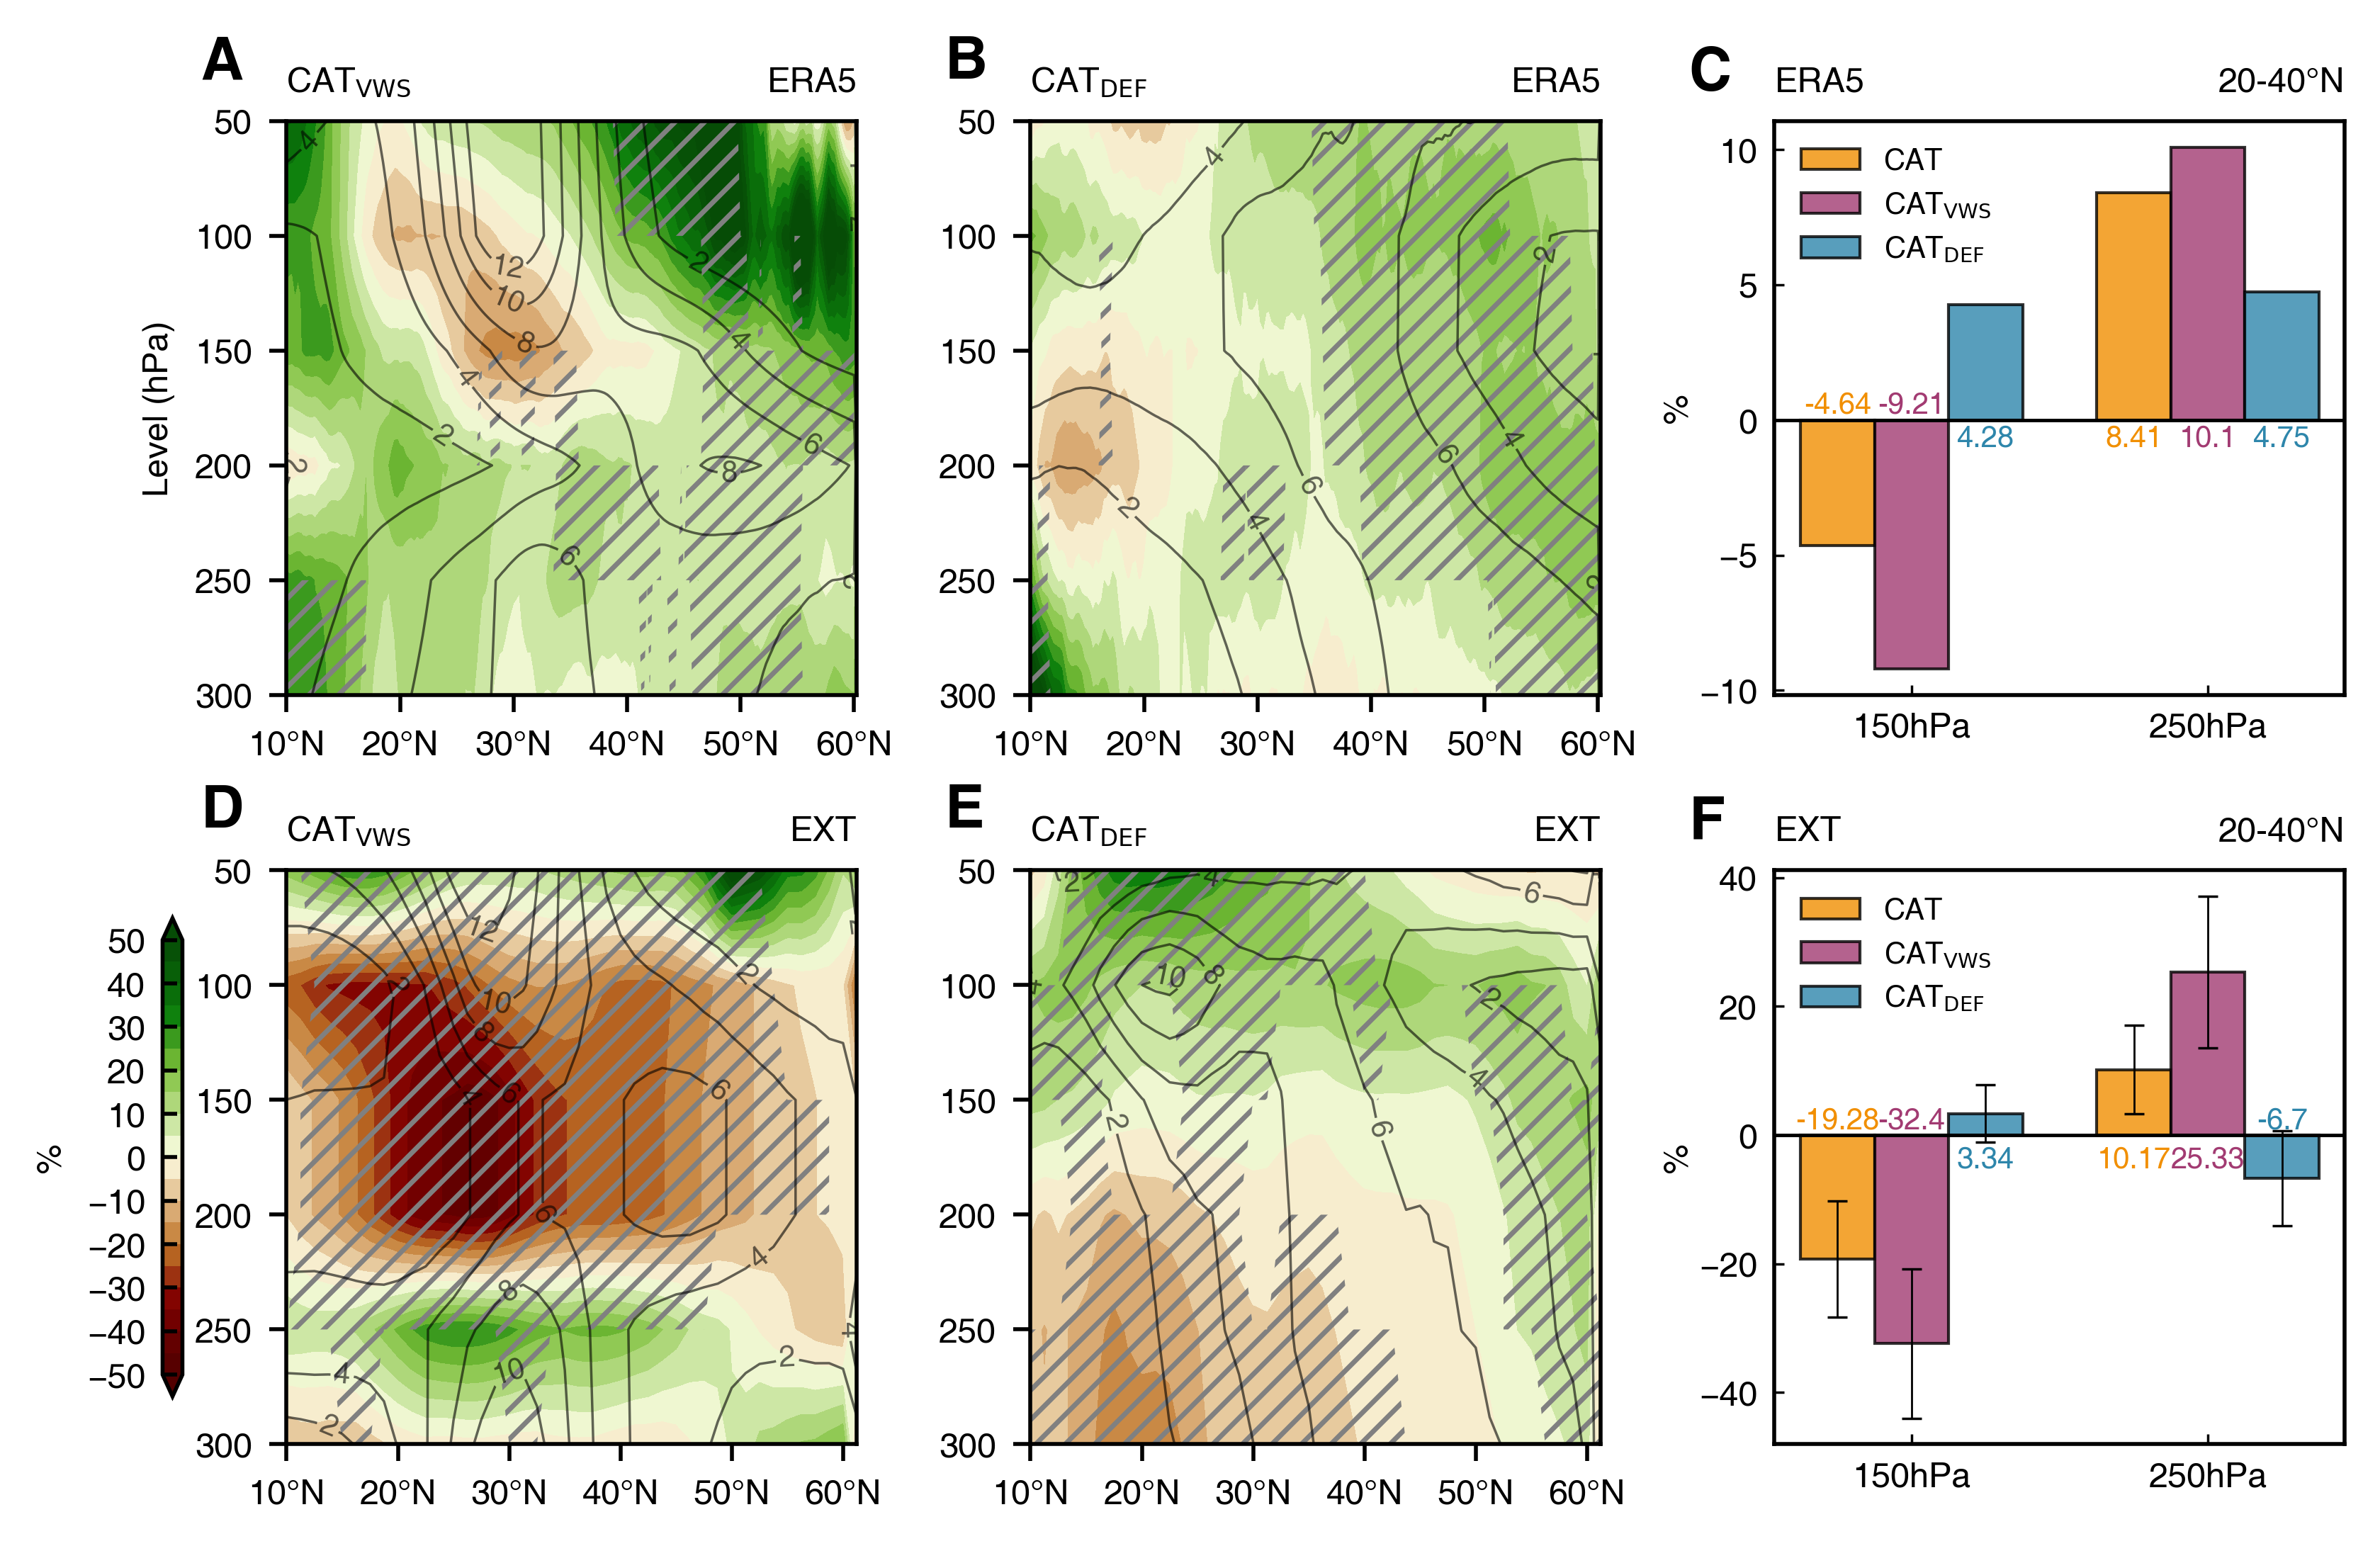

In [20]:
IN_DIR = "/home/dongyl/Work2024/Tl/saved_npy/model_turbulence_data/h+ssp585_1980-2020/95p_frequency"
level_label = ['300', '250', '200', '150', '100', '50']
lat = xr.open_dataset(f"{IN_DIR}/TI1_h+ssp585_BCC-CSM2-MR_1980-2020_exceed_pct_95p.nc").lat.values
lat_indices = np.where((lat >= 10) & (lat <= 60))[0]
lat = xr.open_dataset(f"{IN_DIR}/TI1_h+ssp585_BCC-CSM2-MR_1980-2020_exceed_pct_95p.nc").lat[lat_indices].values
level = xr.open_dataset(f"{IN_DIR}/TI1_h+ssp585_BCC-CSM2-MR_1980-2020_exceed_pct_95p.nc").plev[1:7]

file1 = f"/home/share-to-3/dongyl/cmip_day/interpolated_remapbiled_289x145/N_hemisphere_1980-2020_daytomon/ua_h+ssp585_{model}_1980-2020_N_interpolated_288x145_monmean.nc"
ua_h_ssp585 = xr.open_dataset(file1).ua_interp
print(ua_h_ssp585.plev)
#pout = (/100000., 92500., 85000., 70000., 50000., 30000., 25000., 20000., 15000., 10000., 5000., 1000./)
ua_h_ssp585_plev = ua_h_ssp585.plev[4:10]
h_ssp585_level_label = list(map(int, ua_h_ssp585_plev.data.tolist()))
ua_h_ssp585_plev_lat = ua_h_ssp585.lat.values

fig = plt.figure(figsize=(7, 4.5), dpi=500)
axes = [[0.13, 0.55, 0.23, 0.36], [0.43, 0.55, 0.23, 0.36],[0.73, 0.55, 0.23, 0.36],
         [0.13, 0.08, 0.23, 0.36], [0.43, 0.08, 0.23, 0.36],[0.73, 0.08, 0.23, 0.36]]
abstrend_level=np.linspace(-1, 1, 21)
relatrend_level = np.linspace(-50, 50, 21)

'''plot_meri_section(fig.add_axes(axes[0]), lat, level, level_label, (TI_freq_trend[1:7]/TI_freq_clim[1:7]) *44*100,
                  relatrend_level, ccmap1, TI_freq_clim[1:7],
                  np.arange(0, 13, 2), TI_significant_points[1:7], np.arange(10, 61, 10),
                  'TI1', 'EXT','%', np.linspace(-1, 1, 11), 'a')'''
plot_meri_section(fig.add_axes(axes[3]), lat,level,level_label,(VWS_freq_trend[1:7]/VWS_freq_clim[1:7]) *41*100,
                 relatrend_level,ccmap1,VWS_freq_clim[1:7],
                   np.arange(0, 13, 2),VWS_significant_points[1:7],np.arange(10,61,10),
                      r'CAT$_{\text{VWS}}$','EXT','%',np.linspace(-1, 1, 11),'D')
cf = plot_meri_section(fig.add_axes(axes[4]), lat,level,level_label,(DEF_freq_trend[1:7]/DEF_freq_clim[1:7]) *41*100,
                       relatrend_level,ccmap1,DEF_freq_clim[1:7],
                   np.arange(0, 13, 2),DEF_significant_points[1:7],np.arange(10,61,10),
                      r'CAT$_{\text{DEF}}$','EXT','%',np.linspace(-1, 1, 11),'E')

print('DEF_freq_trend[1:7]')
#print(DEF_freq_trend[1:7])
print('DEF_freq_clim[1:7]')
#print(DEF_freq_clim[1:7])
print('(DEF_freq_trend[1:7]-DEF_freq_clim[1:7])/DEF_freq_clim[1:7]')
#print((DEF_freq_trend[1:7]-DEF_freq_clim[1:7])/DEF_freq_clim[1:7])

lat = xr.open_dataset(f"/home/dongyl/Work2_2025/ERA5_daily/era5_TI1_exceed_pct_{year}_{int(Q * 100)}p.nc").lat.values
lat_indices = np.where((lat >= 10) & (lat <= 60))[0]
lat = xr.open_dataset(f"/home/dongyl/Work2_2025/ERA5_daily/era5_TI1_exceed_pct_{year}_{int(Q * 100)}p.nc").lat[lat_indices].values
level = xr.open_dataset(f"/home/dongyl/Work2_2025/ERA5_daily/era5_TI1_exceed_pct_{year}_{int(Q * 100)}p.nc").plev[:]

'''plot_meri_section(fig.add_axes(axes[3]), lat,level,level_label,(era5_TI_freq_trend/era5_TI_freq_clim)*10*100,relatrend_level,
                  ccmap1,era5_TI_freq_clim,
                   np.arange(0, 13, 2),era5_TI_significant_points,np.arange(10,61,10),
                      'TI1','ERA5','%',np.linspace(-1, 1, 11),'d')'''
plot_meri_section(fig.add_axes(axes[0]), lat,level,level_label,(era5_VWS_freq_trend/era5_VWS_freq_clim)*41*100,relatrend_level,
                  ccmap1,era5_VWS_freq_clim,
                   np.arange(0, 13, 2),era5_VWS_significant_points,np.arange(10,61,10),
                      r'CAT$_{\text{VWS}}$','ERA5','%',np.linspace(-1, 1, 11),'A')
cf = plot_meri_section(fig.add_axes(axes[1]), lat,level,level_label,(era5_DEF_freq_trend/era5_DEF_freq_clim)*41*100,relatrend_level,
                       ccmap1,era5_DEF_freq_clim,
                   np.arange(0, 13, 2),era5_DEF_significant_points,np.arange(10,61,10),
                      r'CAT$_{\text{DEF}}$','ERA5','%',np.linspace(-1, 1, 11),'B')

cbar_ax = fig.add_axes([0.08, 0.11, 0.008, 0.3])  # 调整这些数字以改变colorbar的大小和位置
cb = plt.colorbar(cf,cax=cbar_ax , orientation='vertical', shrink=0.85, pad=0.05, extend='both',location='left')
cb.ax.yaxis.set_major_locator(MultipleLocator(0.2))
cb.set_ticks(np.linspace(-50, 50, 11))
# ax1.tick_params(axis='y', labelsize=8)  # 设置y轴刻度数字大小
cb.ax.tick_params(axis='y', which='major', direction='in', length=3, labelsize=7)
# cb.ax.tick_params(which='minor', direction='in', length=5)
cb.set_label(label='%', fontsize=7)


ax6 =  plot_bar(ax=fig.add_axes(axes[5]),bara1=(TI_all_models_aeram_trend_stack[:,4]/TI_all_models_aream_clim_stack[:,4])*41*100,bara2=(VWS_all_models_aeram_trend_stack[:,4]/VWS_all_models_aream_clim_stack[:,4])*41*100,
 bara3=DEF_all_models_aeram_trend_stack[:,4]/DEF_all_models_aream_clim_stack[:,4]*41*100,
 barb1=TI_all_models_aeram_trend_stack[:,2]/TI_all_models_aream_clim_stack[:,2]*41*100,
 barb2=VWS_all_models_aeram_trend_stack[:,2]/VWS_all_models_aream_clim_stack[:,2]*41*100,
 barb3=DEF_all_models_aeram_trend_stack[:,2]/DEF_all_models_aream_clim_stack[:,2]*41*100,right_title="20-40°N",
                left_title="EXT",sequence='F')

ax3 =  plot_bar_era5(ax=fig.add_axes(axes[2]),bara1=era5_TI_freq_aream_trend[3]/era5_TI_freq_aream_clim[3]*41*100,bara2=era5_VWS_freq_aream_trend[3]/era5_VWS_freq_aream_clim[3]*41*100,
 bara3=era5_DEF_freq_aream_trend[3]/era5_DEF_freq_aream_clim[3]*41*100,
 barb1=era5_TI_freq_aream_trend[1]/era5_TI_freq_aream_clim[1]*41*100,
 barb2=era5_VWS_freq_aream_trend[1]/era5_VWS_freq_aream_clim[1]*41*100,
 barb3=era5_DEF_freq_aream_trend[1]/era5_DEF_freq_aream_clim[1]*41*100,right_title="20-40°N",
                left_title="ERA5",sequence='C')
print(DEF_all_models_aeram_trend_stack.shape)

plt.savefig(f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.S5.VWS_DEF_OBSandEXT_relatrend_meri_section_with_bar.png',format='png', dpi=300)
plt.savefig(f'/home/dongyl/UPWARD_SHIFT_OF_JET_STREAM_DATAFILES/ScienceStyleFigures/Fig.S5.VWS_DEF_OBSandEXT_relatrend_meri_section_with_bar.ps',format='ps', dpi=300)
plt.show()